In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import  pearsonr, spearmanr
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import balanced_accuracy_score, f1_score, accuracy_score, make_scorer
from sklearn.pipeline import make_pipeline
import scipy
import os

from ucimlrepo import fetch_ucirepo

In [2]:
seed = 0
np.random.seed(seed)
os.environ['PYTHONHASHSEED']=str(seed)

# Functions
- Data Processing Functions
- Model Evaluation Functions
- Visualization Functions

## Data Processing Functions
- load_data()
- get_test_and_training_data(test_size=0.2)

In [3]:
## groups are right now 'mother_occupation' and 'Gender'
## HOW SHOULD WE LOAD THE DATA?
def load_data():
    predict_students_dropout_and_academic_success = fetch_ucirepo(id=697)
    df = predict_students_dropout_and_academic_success.data.features

    ## Remove Features related to Curricular units
    df = df[['Marital Status', 'Application mode', 'Application order', 'Course',
           'Daytime/evening attendance', 'Previous qualification',
           'Previous qualification (grade)',
           'Admission grade', 'Displaced', 'Educational special needs', 'Debtor',
           'Tuition fees up to date',
           'International', 'Unemployment rate',
           'Inflation rate', 'GDP',
           "Mother's qualification", "Father's qualification",
           "Mother's occupation", "Father's occupation",
           'Scholarship holder', 'Age at enrollment', 'Nacionality', 'Gender']]


    df_init = df.copy() # TODO: decide wether this is needed

    # Make a binary column for dropout
    data_y = predict_students_dropout_and_academic_success.data.targets
    data_y = data_y.Target.apply(lambda x: 1 if x == 'Dropout' else 0)
    df['Dropout'] = data_y

    # # Make a binary column for mother's and father's class based on their occupations
    # # TODO: check these idx
    # mother_upper_class_occupation = [
    #     1, 2, 122, 123, 125, 131, 132, 134, 141, 143, 144, 153, 173
    # ]
    # father_upper_class_occupations = [
    #     1, 2, 101, 112, 114, 121, 122, 123, 124, 131, 132, 134, 135, 141,
    #     143, 144, 151, 152, 153, 154, 161, 171, 172, 174, 175, 181, 182
    # ]

    # mother_occupation = np.asarray(df.mother_occupation)
    # mother_upper_class_values = [1 if occ in mother_upper_class_occupation else 0 for occ in mother_occupation]
    # father_occupation = np.asarray(df.father_occupation)
    # father_upper_class_values = [1 if occ in father_upper_class_occupations else 0 for occ in father_occupation]
    # df['mother_upper_class'] = mother_upper_class_values
    # df['father_upper_class'] = father_upper_class_values

    # # Remove "Mother's occupation" and "Father's occupation" columns
    # df.drop(columns=["Mother's occupation", "Father's occupation"], axis=1, inplace=True)

    # Make a binary column for portuguese
    nationality = np.asarray(df.Nacionality)
    is_portuguese_values = [1 if n == 1 else 0 for n in nationality]
    df['is_portuguese'] = is_portuguese_values

    # Remove "Nacionality" columns
    df.drop(columns=["Nacionality"], axis=1, inplace=True)


    protected_cols = ['Gender', 'is_portuguese'] # TODO: do something with parents qualitifcation and occupation?? Or other categories

    labels = df[['Dropout']]
    groups = df[protected_cols]

    features_full = df.copy()
    df.drop('Dropout', axis=1, inplace=True)
    features = df.copy()
    features_protected = pd.concat([df[x] for x in protected_cols], axis=1)

    for x in protected_cols:
      df = df.drop(x, axis=1)

    features_np = df.copy()

    return features, features_full, labels, groups, features_np, features_protected, protected_cols


def get_test_and_training_data(features, labels, protected_cols=[], test_size=0.2):
    ## This code is adapted from solution to data debias exercises
    X, y = features, labels
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

    X_train_init = X_train.copy()
    X_test_init = X_test.copy()

    # Subset for protected and non-protected features
    X_train_p = X_train[protected_cols]
    X_train_np = X_train.drop(columns=protected_cols)
    X_test_p = X_test[protected_cols]
    X_test_np = X_test.drop(columns=protected_cols)

    return X_train_init, X_test_init, y_train, y_test, X_train_p, X_train_np, X_test_p, X_test_np


### A Geometric Solution to Fair Representations

In [4]:
def debias_features(X, protected_idx, l=0):
    '''Based on exercises. Debias using de-correllation'''

    #FunctionTransfomer makes it an array and I want it to be a dataFrame
    X = pd.DataFrame(X) #This makes no difference

    X_p = X[protected_idx]
    X_np = X.copy().drop(columns=protected_idx)

    # Find the basis from the protected attributes
    orthbasis = scipy.linalg.orth(X_p)

    # Debias nonprotected features by projecting them onto the basis
    X_np_debiased = X_np - orthbasis @ orthbasis.T @ X_np

    # Return debiased nonprotected features, tempered by lambda: r′_j(λ) = r_j + λ⋅ (x_j− r_j)
    return pd.DataFrame(X_np_debiased + l * (X_np - X_np_debiased))


## Model Evaluation Functions
- standard_scale
- cross_validator
- fairness metrics

In [5]:
def standard_scale(X_train, X_test): ## We need to scale within the cross val step to avoid data leakage
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = pd.DataFrame(scaler.transform(X_train))
    X_test = pd.DataFrame(scaler.transform(X_test))
    return X_train, X_test

In [6]:
def cross_validator(model, X, y, protected_cols=[], n=5, debias=False, lambd=0):
    kfold = KFold(n, shuffle=True, random_state=seed)

    y_hat = np.zeros(len(y))

    for train_idx, test_idx in kfold.split(X, y): ## Split based on both X and y
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]

        X_train, X_test = standard_scale(X_train, X_test)

        if debias:
          protected_idx = [X.columns.get_loc(col) for col in protected_cols]
          X_train = debias_features(X_train, protected_idx, l=lambd) # using decorrelation
          X_test = X_test.copy().drop(columns=protected_idx)

        model = model.fit(X_train, y_train)
        y_hat[test_idx] = model.predict(X_test)

    return y_hat

### Fairness Metrics

In [7]:
''' Based on lecture 3 '''
def group_idx(group_test):
  group_one_idx = [1 for _ in range(len(group_test))]
  group_two_idx = [0 for _ in range(len(group_test))]
  return group_one_idx, group_two_idx

def statistical_parity(y_hat, group_test):
  group_one_idx, group_two_idx = group_idx()
  one_select = np.mean(y_hat[(group_test == group_one_idx).flatten()])
  two_select = np.mean(y_hat[(group_test == group_two_idx).flatten()])
  statistical_parity = one_select == two_select
  return (statistical_parity, two_select, one_select)

def equalized_odds(y_hat, y_test, group_test):
  group_one_idx, group_two_idx = group_idx()

  one_tpr_0 = np.mean(y_hat[(y_test == 0) & (group_test == group_one_idx).flatten()])
  two_tpr_0 = np.mean(y_hat[(y_test == 0) & (group_test == group_two_idx).flatten()])
  one_tpr_1 = np.mean(y_hat[(y_test == 1) & (group_test == group_one_idx).flatten()])
  two_tpr_1 = np.mean(y_hat[(y_test == 1) & (group_test == group_two_idx).flatten()])

  equalized_odds = ((one_tpr_0 == two_tpr_0), (one_tpr_1 == two_tpr_1))
  return (equalized_odds, (two_tpr_0, one_tpr_0), (two_tpr_1, one_tpr_1))


def equal_outcome(y_hat, y_test, group_test):
  group_one_idx, group_two_idx = group_idx()
  one_ppr_0 = np.mean(y_test[(y_hat == 0) & (group_test == group_one_idx).flatten()])
  two_ppr_0 = np.mean(y_test[(y_hat == 0) & (group_test == group_two_idx).flatten()])
  one_ppr_1 = np.mean(y_test[(y_hat == 1) & (group_test == group_one_idx).flatten()])
  two_ppr_1 = np.mean(y_test[(y_hat == 1) & (group_test == group_two_idx).flatten()])

  fpr = one_ppr_0 == two_ppr_0
  tpr = one_ppr_1 == two_ppr_1
  equalized_outcome = (fpr, tpr)
  return (equalized_outcome, (two_ppr_0, one_ppr_0), (two_ppr_1, one_ppr_1)) # first s=0, then s=1


## Visualization Functions

In [8]:
def corr_mat(X, method='pearson'):
    '''The code is adapted from solution to data debias exercises
    Takes a dataframe and computes the correlations, and their
    statistical significance between all features,
    returning 2 arrays: correlations, and p_values'''
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Compute correlation matrix
    n_features = X.shape[1]

    corr_ = np.zeros((n_features, n_features))
    p_ = np.zeros((n_features, n_features))

    if method == 'pearson':
        corr_func = pearsonr
    elif method == 'spearman':
        corr_func = spearmanr
    else:
        raise ValueError("Unsupported correlation method. Supported methods are 'pearson' and 'spearman'.")

    for i in range(n_features):
        for j in range(n_features):
            corr_[i,j], p_[i,j] = corr_func(X[:,i], X[:,j])
            corr_ = np.nan_to_num(corr_, 0)
            # Handle NaN values in correlation coefficient by setting p-value to 1
            if np.isnan(corr_[i,j]):
                p_[i,j] = 1

    return corr_, p_

def plot_corr(df, method='pearson', protected_cols=[], show_protected_features=False):
    corr, p = corr_mat(df, method)

    alpha = 0.05 # Significance level
    corrected_alpha = alpha / (df.shape[1]**2/2) #bonferronni correction,

    if show_protected_features:
      plt.figure(figsize=(len(protected_cols),9))

      protected_idx = [df.columns.get_loc(col) for col in protected_cols]

      sns.heatmap(corr[:, protected_idx], cmap="coolwarm", xticklabels=df.columns[protected_idx], yticklabels=df.columns,
            mask = p[:, protected_idx]  > corrected_alpha, vmin=-1, vmax=1, square=True)
    else:
      plt.figure(figsize=(15,15))
      sns.heatmap(corr, cmap="coolwarm",
                  xticklabels=df.columns, yticklabels=df.columns,
                  square=True, vmin=-1, vmax=1, mask= p > corrected_alpha)

    corr_name = ""
    if method == 'pearson':
        corr_name = "Pearson's "
    elif method == 'spearman':
        corr_name = "Spearman's "
    else:
        raise ValueError("Unsupported correlation method. Supported methods are 'pearson' and 'spearman'.")

    plt.title(f"{corr_name}Correlation Coeff between all features (filtered by p > {alpha})")
    plt.show()

# Load Data

In [9]:
features, features_full, labels, groups, features_np, features_protected, protected_cols = load_data()
X_train, X_test, y_train, y_test, X_train_p, X_train_np, X_test_p, X_test_np = get_test_and_training_data(features, labels, protected_cols=protected_cols)

/var/folders/xd/wqwh0fmd6ss4z2j1hvdztrrm0000gn/T/ipykernel_98883/115757629.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Dropout'] = data_y
/var/folders/xd/wqwh0fmd6ss4z2j1hvdztrrm0000gn/T/ipykernel_98883/115757629.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['is_portuguese'] = is_portuguese_values
/var/folders/xd/wqwh0fmd6ss4z2j1hvdztrrm0000gn/T/ipykernel_98883/115757629.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats 

# Exploratory Data Analysis (EDA)

In [10]:
features_full.describe().T

,count,mean,std,min,25%,50%,75%,max
Marital Status,4424.0,1.178571,0.605747,1.00,1.0,1.00,1.00,6.00
Application mode,4424.0,18.669078,17.484682,1.00,1.0,17.00,39.00,57.00
Application order,4424.0,1.727848,1.313793,0.00,1.0,1.00,2.00,9.00
Course,4424.0,8856.642631,2063.566416,33.00,9085.0,9238.00,9556.00,9991.00
Daytime/evening attendance,4424.0,0.890823,0.311897,0.00,1.0,1.00,1.00,1.00
Previous qualification,4424.0,4.577758,10.216592,1.00,1.0,1.00,1.00,43.00
Previous qualification (grade),4424.0,132.613314,13.188332,95.00,125.0,133.10,140.00,190.00
Admission grade,4424.0,126.978119,14.482001,95.00,117.9,126.10,134.80,190.00
Displaced,4424.0,0.548373,0.497711,0.00,0.0,1.00,1.00,1.00
Educational special needs,4424.0,0.011528,0.106760,0.00,0.0,0.00,0.00,1.00


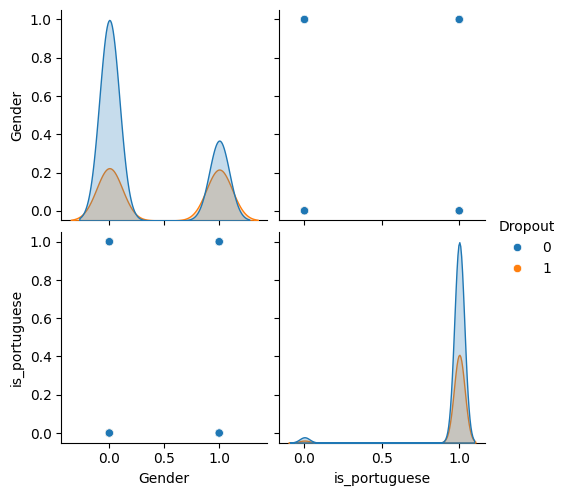

In [11]:
sns.pairplot(data=features_full, x_vars=protected_cols, y_vars=protected_cols, hue='Dropout', diag_kind='kde');

                Course
Gender Dropout        
0      0          2148
       1           720
1      0           855
       1           701


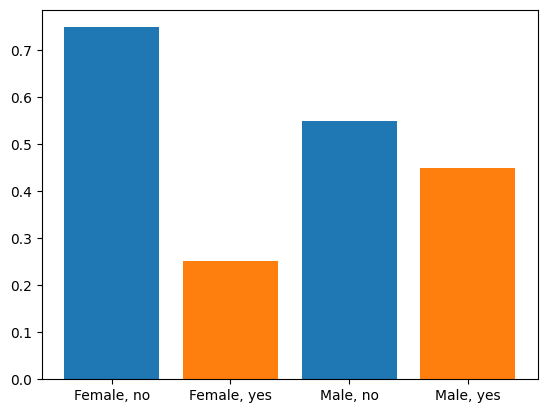

In [12]:
males = features_full[features_full.Gender==1].shape[0]
females = features_full[features_full.Gender==0].shape[0]

X = pd.DataFrame(features_full.groupby(['Gender', 'Dropout']).count().Course)

print(X)

plt.bar([0,1,2,3], X.Course/[females, females, males, males], color=['tab:blue','tab:orange','tab:blue','tab:orange'])
plt.xticks([0,1,2,3],  labels=['Female, no', 'Female, yes','Male, no', 'Male, yes']);

                       Course
is_portuguese Dropout        
0             0            78
              1            32
1             0          2925
              1          1389


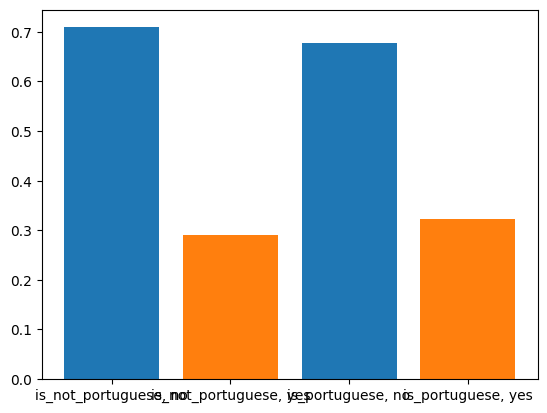

In [13]:
is_portuguese = features_full[features_full.is_portuguese==1].shape[0]
is_not_portuguese = features_full[features_full.is_portuguese==0].shape[0]

X = pd.DataFrame(features_full.groupby(['is_portuguese', 'Dropout']).count().Course)

print(X)

plt.bar([0,1,2,3], X.Course/[is_not_portuguese, is_not_portuguese, is_portuguese, is_portuguese], color=['tab:blue','tab:orange','tab:blue','tab:orange'])
plt.xticks([0,1,2,3],  labels=['is_not_portuguese, no', 'is_not_portuguese, yes','is_portuguese, no', 'is_portuguese, yes']);

# Try things out...

In [14]:
features, features_full, labels, groups, features_np, features_protected, protected_cols = load_data()
X_train, X_test, y_train, y_test, X_train_p, X_train_np, X_test_p, X_test_np = get_test_and_training_data(features, labels, protected_cols=protected_cols)

/var/folders/xd/wqwh0fmd6ss4z2j1hvdztrrm0000gn/T/ipykernel_98883/115757629.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Dropout'] = data_y
/var/folders/xd/wqwh0fmd6ss4z2j1hvdztrrm0000gn/T/ipykernel_98883/115757629.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['is_portuguese'] = is_portuguese_values
/var/folders/xd/wqwh0fmd6ss4z2j1hvdztrrm0000gn/T/ipykernel_98883/115757629.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats 

In [15]:
features_np.columns

Index(['Marital Status', 'Application mode', 'Application order', 'Course',
       'Daytime/evening attendance', 'Previous qualification',
       'Previous qualification (grade)', 'Admission grade', 'Displaced',
       'Educational special needs', 'Debtor', 'Tuition fees up to date',
       'International', 'Unemployment rate', 'Inflation rate', 'GDP',
       'Mother's qualification', 'Father's qualification',
       'Mother's occupation', 'Father's occupation', 'Scholarship holder',
       'Age at enrollment'],
      dtype='object')

In [16]:
model = LogisticRegression(max_iter=5000, penalty="l2", C=0.8497534359086438, tol=1e-4, solver="saga")
#logreg_preds = cross_validator(model, X_train, y_train, debias=False)
logreg_preds = cross_validator(model, X_train, y_train, protected_cols, debias=False)
logreg_preds

/usr/local/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

array([1., 0., 1., ..., 0., 0., 0.])

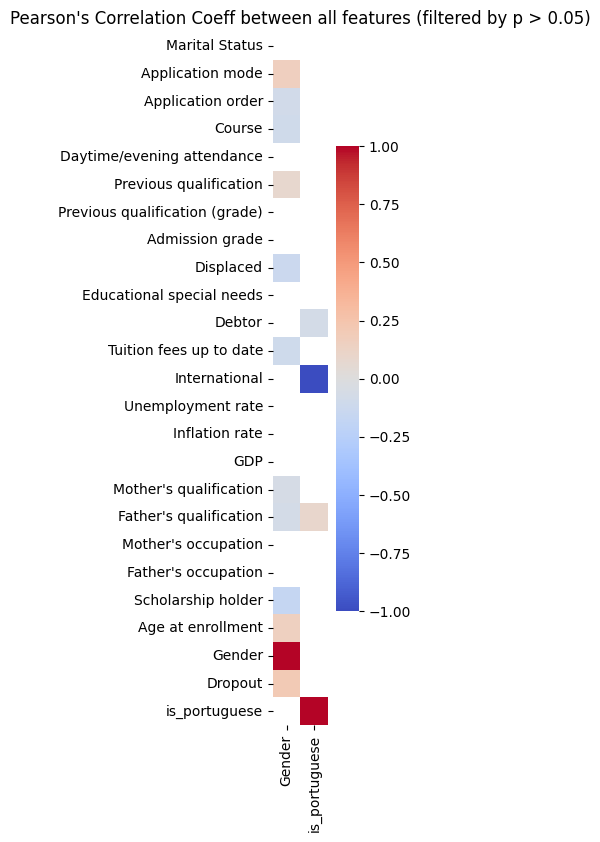

In [17]:
plot_corr(features_full,protected_cols=protected_cols, show_protected_features=True)